In [2]:
# reload modules without reloading explicitly
import importlib
%load_ext autoreload
%autoreload 2

In [3]:
#specify ""matplotlib notebook"" for resizeable inline plots:
# works in jupyter notebook
%matplotlib notebook 
# works in vs code; may need to ""pip install ipympl""
#%matplotlib widget
import os
from pathlib import Path
from PIL import Image
from PIL import ImageOps
import matplotlib.pyplot as plt
import numpy as np

In [4]:
p = Path('./cam-09')
filegen = p.glob('**/*.jpg')
path = next(filegen)
img  = Image.open(path) 

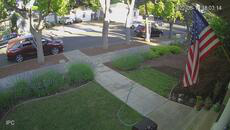

In [5]:
img

<IPython.core.display.Javascript object>


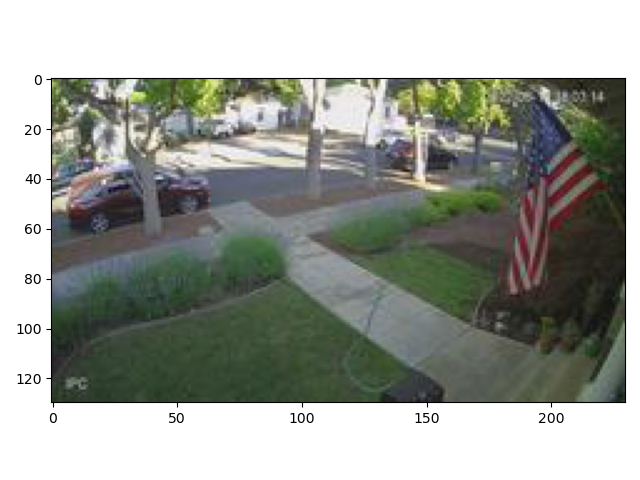

In [6]:
plt.figure()
plt.imshow(np.asarray(img))
plt.tight_layout()

In [7]:
x = np.asarray( ImageOps.grayscale(img))
x.shape

(130, 230)

<IPython.core.display.Javascript object>


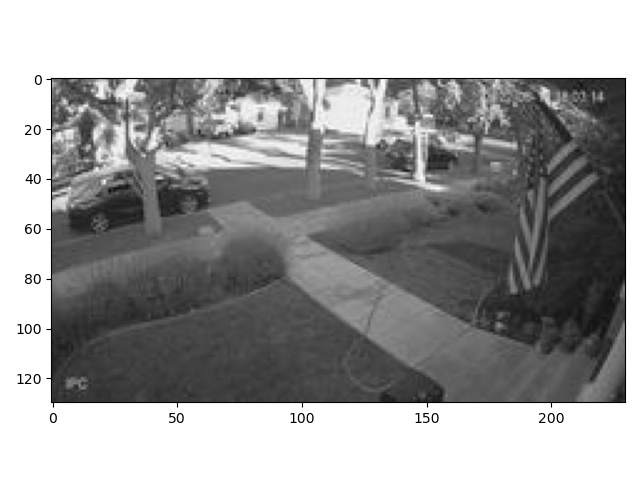

In [8]:
plt.figure()
plt.imshow(x, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [9]:
#
# compute mean over all axes
image_mean = np.mean(x)
print(image_mean)
print(np.min(x))

97.49913043478261
8


-5.840233536468302e-15


<IPython.core.display.Javascript object>


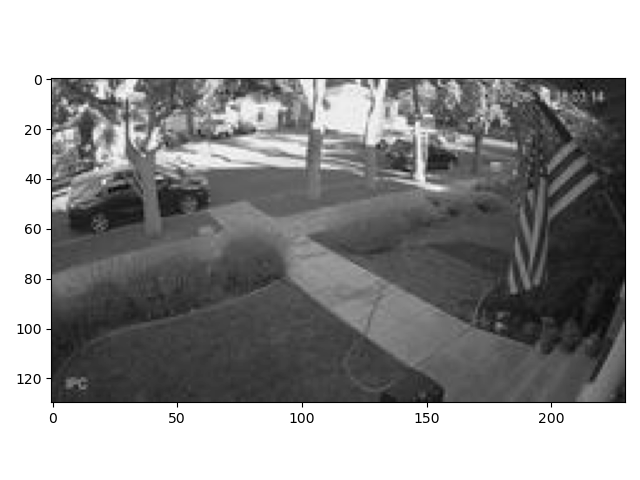

In [10]:
x_centered = x - image_mean
print(np.mean(x_centered))
plt.figure()
#plt.imshow(x_centered,cmap='gray', vmin=np.min(x_centered), vmax=np.max(x_centered))
plt.imshow(x_centered,cmap='gray')
plt.tight_layout()
plt.show()

In [11]:
#
# perform SVD
U,s,Vt = np.linalg.svd(x_centered,full_matrices=False)
print(f"x_centered.shape = {x_centered.shape}")
print(f"U.shape = {U.shape}")
print(f"s.shape = {s.shape}")
print(f"Vt.shape = {Vt.shape}")

x_centered.shape = (130, 230)
U.shape = (130, 130)
s.shape = (130,)
Vt.shape = (130, 230)


<IPython.core.display.Javascript object>


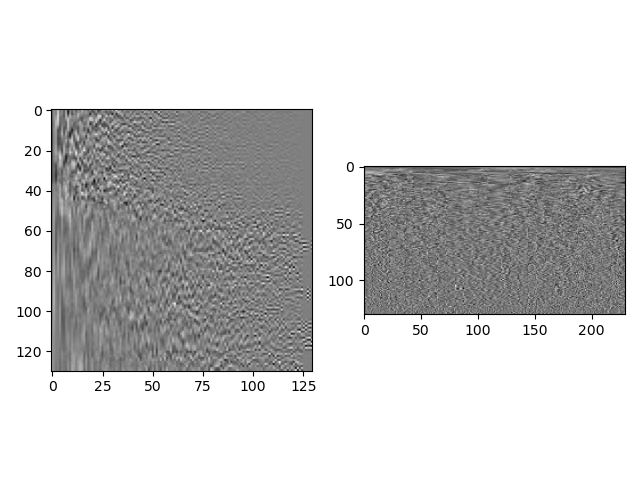

In [12]:
fig,ax=plt.subplots(1,2)
ax[0].imshow(U,cmap='gray')
ax[1].imshow(Vt,cmap='gray')
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


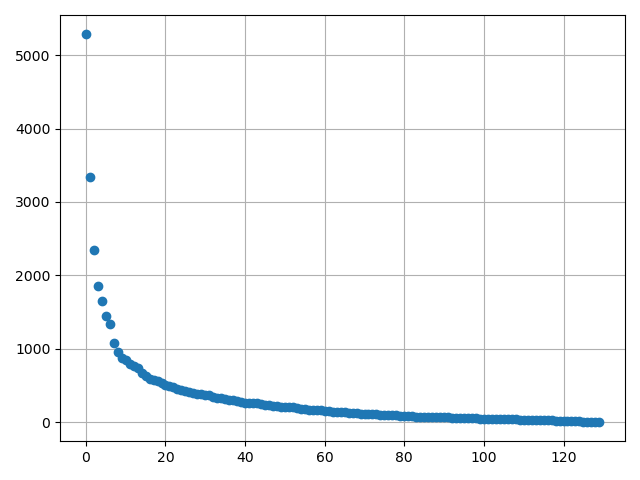

In [14]:
fig,ax=plt.subplots()
ax.plot(s,'o')
plt.tight_layout()
plt.grid(True)
plt.show()

In [16]:
# autocorrelation?
# XXt?
x_centered.transpose().shape

(230, 130)

In [17]:
XXt = np.matmul(x_centered, x_centered.transpose())

In [18]:
print(XXt.shape)

(130, 130)


<IPython.core.display.Javascript object>


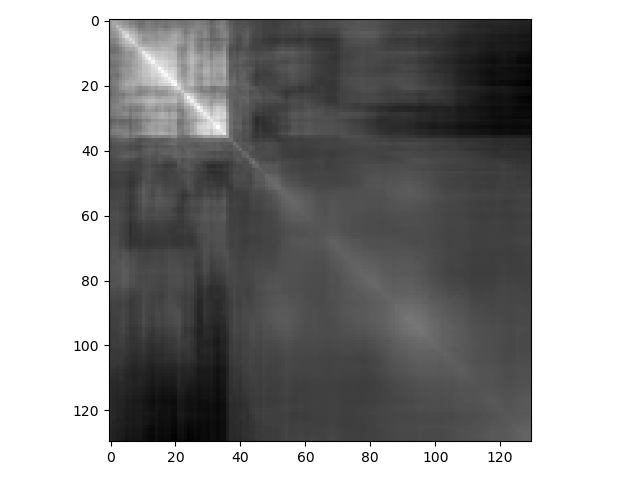

In [19]:
#
# what does autocorrelation look like?
fig,ax=plt.subplots()
ax.imshow(XXt,cmap='gray')
plt.tight_layout()
plt.show()

In [20]:
#
# SVD of image autocorrelation XXt yields same results as SVD(X)
U2,s2,V2t = np.linalg.svd(XXt)
print(U2.shape)
print(s2.shape)
print(V2t.shape)

(130, 130)
(130,)
(130, 130)


<IPython.core.display.Javascript object>


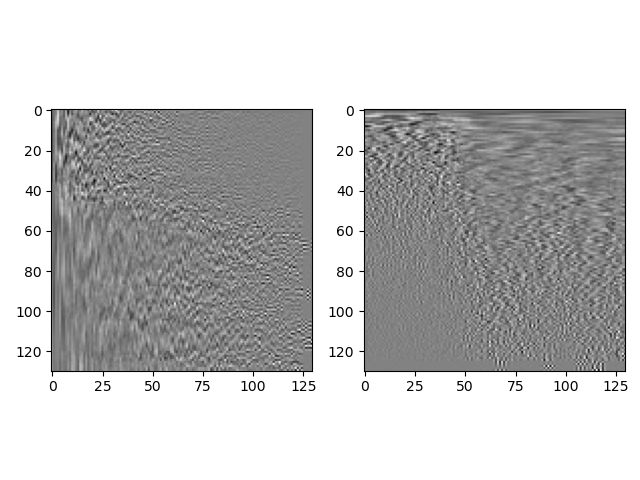

In [21]:
fig,ax=plt.subplots(1,2)
ax[0].imshow(U2,cmap='gray')
ax[1].imshow(V2t,cmap='gray')
plt.tight_layout()
plt.show()


<IPython.core.display.Javascript object>


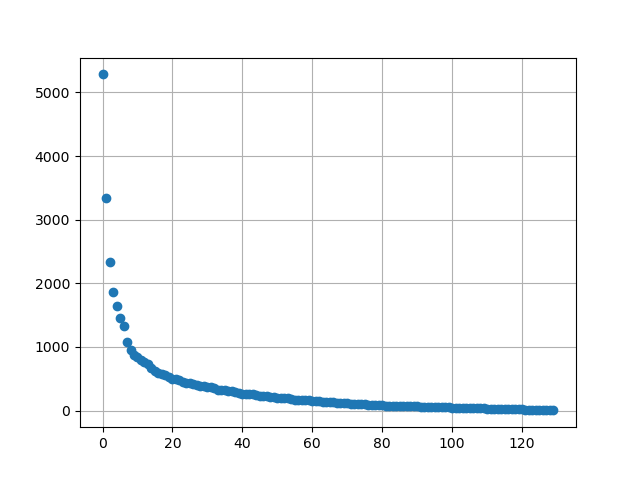

In [22]:
fig,ax=plt.subplots()
ax.plot(np.sqrt(s2),'o')
plt.grid(True)
plt.show()

In [23]:
#
# rank-N approximation
def rank_approx(X, m):
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    sm = np.zeros(s.shape)
    
    #s = np.ones(len(s))
    
    sm[0:m] = s[0:m]
    Sm = np.diag( sm)
    US = np.matmul(U, Sm)
    Y = np.matmul(US, Vt)
    return Y, U, s, Vt
    

(130, 230)


<IPython.core.display.Javascript object>


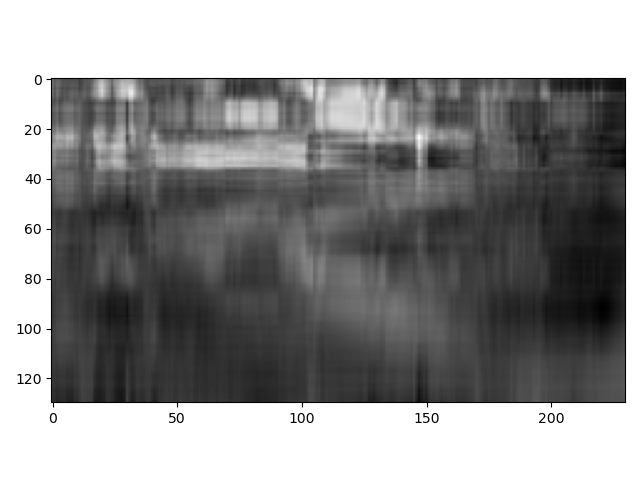

In [24]:
Y, U, s, Vt = rank_approx(x_centered, 5)
print(Y.shape)
fig,ax=plt.subplots()
ax.imshow(Y,cmap='gray')
plt.tight_layout()
plt.show()

In [28]:
# singular vecs are orthogonal
np.matmul(U[:,4],U[:,5].transpose())

2.480654570646834e-16

In [27]:
# singular vecs are unit length
np.matmul(U[:,4],U[:,4].transpose())

1.0000000000000009

In [82]:
#
# how does whitening the image affect the results?
#
#
# given X, you can get whitened version Xw = inv(s) * E.transpose * X
# where
# E and s are results of eigencomposition
#
print(f"initial mean={np.mean(x_centered)}")
print(f"var(x_centered)={np.var(x_centered)}")

Rxx = np.matmul(x_centered, x_centered.transpose())
print(Rxx.shape)
print(f"Initial covariance[0..5] = {(np.diag(Rxx))[0:5]}")

#
# do eigencomposition
s, V = np.linalg.eig(Rxx)
#print(s.shape)
#print(V.shape)

# invert s; remember that s is returned as vector representing the diagonals
s_isr = 1.0/np.sqrt(s)  # inverse square root
#print(s_isr[0])  
#print(s_isr[0] * s[0])

#print(np.matmul(V, (V.transpose())))


x_w = np.matmul(V.transpose(), x_centered)
x_w = np.matmul(np.diag(s_isr), x_w)

#
# the variance values of the new covariance matrix should
# be all unity
print(x_w.shape)
Rxw = np.matmul(x_w, x_w.transpose())
print(f"Final covariance[0..5] = {(np.diag(Rxw))[0:5]}")

initial mean=-5.840233536468302e-15
var(x_centered)=2216.339296902719
(130, 130)
Initial covariance[0..5] = [ 702750.50713043  720972.95408696  859993.74713043  921835.48973913
 1007014.7053913 ]
(130, 230)
Final covariance[0..5] = [1. 1. 1. 1. 1.]


In [81]:
# how does this relate to SVD(x_centered)?
#
# svd(x_centered) should return the same decomposition as svd(Rxx), except
# the singular values of svd(x_centered) are the SQUARE ROOT of eig(Rxx)
U, s, Vt = np.linalg.svd(x_centered, full_matrices=False)
print(1.0/s[0])
print(s_isr[0])
assert(np.isclose(1.0/s[0], s_isr[0]))

0.00018930332938235395
0.00018930332938235392


<IPython.core.display.Javascript object>


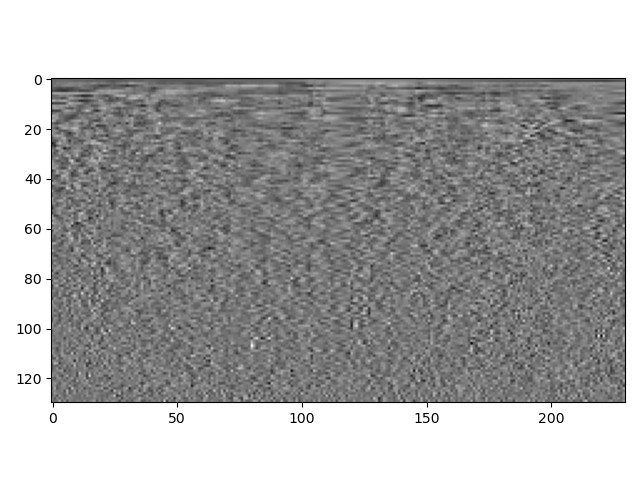

In [88]:
#
# what does the whitened image look like?
plt.figure()
#plt.imshow(x_centered,cmap='gray', vmin=np.min(x_centered), vmax=np.max(x_centered))
plt.imshow(x_w,cmap='gray')
plt.tight_layout()
plt.show()
#
# whoa! that doesn't look like the original at all

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


<IPython.core.display.Javascript object>


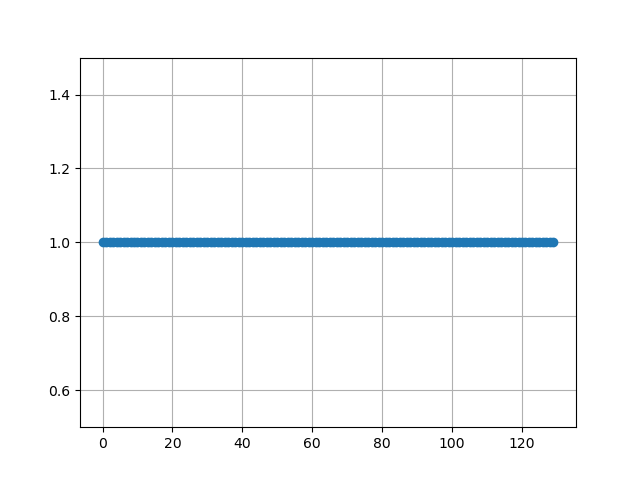

In [106]:
#
# what does the eigendecomposition look like for X whitened?
sw, Vw = np.linalg.eig(Rxw)

print(sw[0:10])
fig,ax=plt.subplots()
ax.plot(sw,'o')
ax.set_ylim([0.5,1.5])  # automatic y-axis setting fails without this!
#plt.tight_layout()
plt.grid(True)
plt.show()

# they're all unity